<a href="https://colab.research.google.com/github/EinarLop/ML_LAB_3_RL/blob/main/StockTrading_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
The goal of this project is to create and train a reinforcement learning agent to make stock trading decisions. The agent interacts with a custom stock trading environment built using OpenAI Gym, where the agent can take three possible actions: buy, sell, or hold. The environment is based on historical stock price data, with the agent observing a sliding window of past prices and using that information to predict the best trading action.

In this project, we used the Proximal Policy Optimization (PPO) algorithm from the Stable-Baselines3 library to train the agent. The PPO algorithm is well-suited for environments with continuous and discrete actions, and it uses an actor-critic model to balance exploration and exploitation. The agent's performance is evaluated by tracking its cumulative profit and plotting the profit curve over time.

We chose Apple Inc. (AAPL) stock data for this project, which spans from January 2010 to January 2022. The environment was designed to simulate the decision-making process of a trader, and the agent was trained to optimize its actions to maximize profit over time.



## Next steps: Create Custom NN
1. Define a Custom Neural Network (NN) Architecture:
Create the custom NN class: Start by defining a new neural network that will be used to approximate the policy or value function. This could involve using fully connected layers (nn.Linear), or if you want to capture sequential dependencies, you could include recurrent layers like LSTM (nn.LSTM) or GRU (nn.GRU).
Input Layer: The input layer should match the shape of your state space (e.g., stock price data, technical indicators). For a simple approach, this could be the window size (e.g., 10) and the number of features (e.g., 5: open, close, high, low, volume).
Hidden Layers: Decide on the number of hidden layers and units per layer. Use activation functions like ReLU to introduce non-linearity.
Output Layer: The output should match the number of actions (buy, hold, sell). For example, if you're using an actor-critic model, you would have an output for both the policy (actions) and the value function.
2. Integrate the Custom NN with Stable-Baselines3:
Custom Policy Class: To integrate your custom NN into Stable-Baselines3, subclass the ActorCriticPolicy class from Stable-Baselines3. In this subclass, you will need to specify the custom NN as the model for both the actor and the critic.
Override Methods: Override the appropriate methods (__init__, forward, etc.) to use your custom NN for policy and value predictions.
3. Training Setup:
Modify Model Initialization: When initializing the PPO model (or whichever RL algorithm you're using), pass the custom policy class to the model. This will tell Stable-Baselines3 to use your custom NN instead of the default policy.
Environment Setup: Ensure that the environment provides the correct observations (states) that match the input requirements of your custom NN.
4. Tune the Neural Network:
Hyperparameter Tuning: Experiment with different numbers of layers, units per layer, and activation functions. A custom NN might require tuning to ensure it works well for stock price prediction and trading.
Optimizer and Learning Rate: Stable-Baselines3 allows you to specify custom optimizers, so experiment with different optimizers (e.g., Adam, SGD) and adjust the learning rate.
Regularization: You may want to add dropout layers to prevent overfitting, especially since stock data can be noisy.
5. Re-train the Model:
Training the PPO Model: After integrating the custom NN, retrain the model by running the learn() method on the PPO model. Monitor how the performance evolves with the custom NN architecture.
Performance Evaluation: Evaluate how well the model is performing by testing the agent in the environment, and adjust the model and learning parameters based on the results.
6. Monitor and Visualize Results:
Plot Profit/Loss Curve: As you did before, plot the cumulative profit/loss over time to see how well the agent performs with the new model.
Action Visualizations: Continue visualizing trading actions (buy/sell) on the price chart to track whether the agent is making reasonable decisions.
7. Iterate and Improve:
Experiment with More Complex Architectures: If the performance is not as expected, consider more advanced architectures like LSTMs, GRUs, or attention-based models.
Fine-tuning: Fine-tune the network architecture and hyperparameters based on the results you observe, adjusting based on how well the model generalizes to new data.



In [ ]:
!pip install stable-baselines3 gymnasium gym-anytrading yfinance shimmy

In [ ]:
import matplotlib.pyplot as plt
import gym
import gym_anytrading
import yfinance as yf
from gym import spaces
import numpy as np
import pandas as pd

In [49]:
import gym
import numpy as np
import pandas as pd
import yfinance as yf
from gym import spaces

# Download stock data for Apple (AAPL)
df = yf.download('AAPL', start='2010-01-01', end='2022-01-31')  # Fetch historical stock data
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Select relevant features
df = df.fillna(method='ffill')  # Fill missing values with the previous day's data

# Define a custom stock trading environment using OpenAI Gym
class CustomStocksEnv(gym.Env):
    """Custom reinforcement learning environment for stock trading."""

    def __init__(self, df, window_size=2, frame_bound=(10, 500)):
        """
        Initialize the environment.

        Args:
            df (pd.DataFrame): Stock market data.
            window_size (int): Number of past observations to include in the state.
            frame_bound (tuple): Defines the starting and ending indices for training.
        """
        super(CustomStocksEnv, self).__init__()
        self.df = df
        self.window_size = window_size
        self.frame_bound = frame_bound

        # Define the action space: 0 = Buy, 1 = Hold, 2 = Sell
        self.action_space = spaces.Discrete(3)

        # Define the observation space: Stock market data over the past `window_size` days
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(window_size, df.shape[1]), dtype=np.float32
        )

    def reset(self):
        """
        Reset the environment to its initial state.

        Returns:
            np.ndarray: Initial observation.
        """
        self.current_step = self.frame_bound[0]  # Start at the defined frame bound
        self.done = False
        return self.get_observation()

    def get_observation(self):
        """
        Get the current observation (state).

        Returns:
            np.ndarray: Stock market data for the last `window_size` days.
        """
        return np.array(self.df.iloc[self.current_step - self.window_size:self.current_step].values)

    def step(self, action):
        """
        Take an action in the environment.

        Args:
            action (int): 0 = Buy, 1 = Hold, 2 = Sell.

        Returns:
            tuple: (observation, reward, done, info)
        """
        self.current_step += 1
        if self.current_step >= self.frame_bound[1]:
            self.done = True  # Stop the episode if we reach the frame bound
        else:
            self.done = False

        # Reward is currently a placeholder (to be improved later)
        reward = 0
        return self.get_observation(), reward, self.done, {}

    def _current_price(self):
        """
        Get the stock price at the current step.

        Returns:
            float: Closing price of the stock.
        """
        return self.df.iloc[self.current_step]["Close"]

# Register the custom environment in Gym
gym.envs.registration.register(
    id="stocks-v0",
    entry_point="__main__:CustomStocksEnv",
    kwargs={"df": df, "window_size": 10, "frame_bound": (10, 100)},
)

# Create the environment
env = gym.make('stocks-v0')

# Check environment info
print(env)


[*********************100%***********************]  1 of 1 completed

<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<CustomStocksEnv<stocks-v0>>>>>



<ipython-input-49-f84dfcfe99c9>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Fill missing values with the previous day's data
/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment stocks-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 5)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new st

In [50]:
import matplotlib.pyplot as plt

def plot_profit_curve(profits):
    """
    Plots the cumulative profit over time.

    Args:
        profits (list or np.array): Cumulative profit values at each time step.
    """
    plt.figure(figsize=(12, 6))

    # Plot cumulative profit/loss
    plt.plot(profits, label='Cumulative Profit/Loss', color='purple', linewidth=1.5)

    # Draw a horizontal line at zero profit for reference
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Break-even Line')

    # Titles and labels
    plt.title('Trading Agent Profit/Loss Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Profit ($)')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


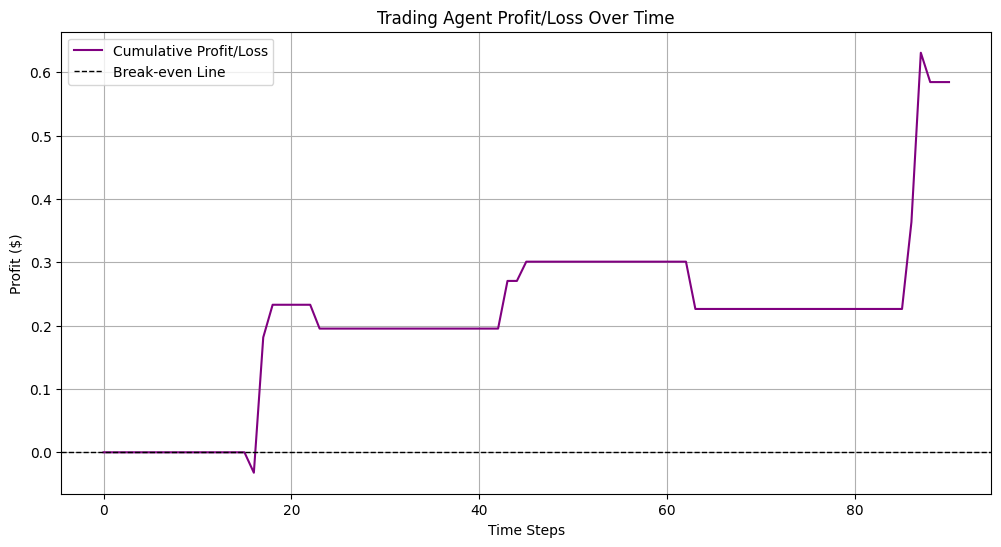

In [52]:
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
import numpy as np

# Initialize PPO model
model = PPO(ActorCriticPolicy, env, verbose=0)

# Train the model for 1 timestep (for quick testing, should be increased)
model.learn(total_timesteps=1000)

# Save the trained model
model.save("ppo_stock_trading_model")

# Define initial trading parameters
initial_balance = 10_000  # Starting cash balance
balance = initial_balance  # Current cash balance
shares_held = 0  # Number of shares owned
profits = [0]  # Track profit/loss over time

# Reset the environment before testing
obs = env.reset()

# Simulate trading for up to 1000 steps
for _ in range(1000):
    action, _state = model.predict(obs, deterministic=True)  # Get action from trained model
    obs, reward, done, info = env.step(action)  # Execute action in the environment

    # Get the current stock price
    current_price = env.unwrapped._current_price()

    # Update balance based on action taken
    if action == 1:  # Buy action
        shares_held += 1
        balance -= current_price
    elif action == 2 and shares_held > 0:  # Sell action (only if shares are held)
        shares_held -= 1
        balance += current_price

    # Compute total account value (cash + value of held stocks)
    total_value = balance + (shares_held * current_price)

    # Calculate profit/loss relative to initial balance
    profit = total_value - initial_balance
    profits.append(profit)

    # End simulation if environment signals completion
    if done:
        break

# Convert profits to a numeric array (handling potential Pandas Series values)
profits = np.array([float(p.values[0]) if isinstance(p, pd.Series) else float(p) for p in profits])

# Plot the profit/loss curve
plot_profit_curve(profits)

# Close the environment
env.close()
